In [1]:
from tensorflow import keras
from keras.datasets import mnist
from keras.layers import *
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential,Model
from keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt
import math
import os



Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
os.chdir('/content/drive/My Drive/Aayush')

In [0]:
(x_train,_), (_,_) = mnist.load_data()

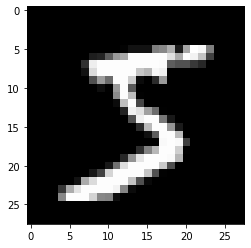

In [34]:
plt.imshow(x_train[0],cmap='gray')
plt.show()

In [35]:
#Normalize this data in the range [-1,1]
x_train = (x_train.astype('float32') - 127.5)/127.5
print(np.min(x_train))
print(np.max(x_train))

-1.0
1.0


In [36]:
print(x_train.shape)

(60000, 28, 28)


In [0]:
TOTAL_EPOCHS = 50
BATCH_SIZE = 256
NO_OF_BATCHES = int(x_train.shape[0]/BATCH_SIZE)
HALF_BATCH = 128
NOISE_DIM = 100   #Upsample this into 784 Dim Vector
adam = keras.optimizers.Adam(learning_rate=2e-4,beta_1=0.5)

In [39]:
#GENERATOR - neural network
#Input Noise (100 Dimension) and Outputs a vector (784 Dimension)

generator = Sequential()
generator.add(Dense(256,input_shape=(NOISE_DIM,)))
generator.add(LeakyReLU(0.2))
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))
generator.add(Dense(784,activation='tanh'))

generator.compile(loss='binary_crossentropy', optimizer=adam)
generator.summary()



Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 784)              

In [40]:
# DISCRIMINATOR - neural network
# Now we will do downsampling.

discriminator = Sequential()
discriminator.add(Dense(512,input_shape=(784,)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dense(1,activation='sigmoid'))         

discriminator.compile(loss='binary_crossentropy',optimizer=adam)    #We have used binary_crossentropy as there are only 2 classes , Real and Fake

discriminator.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________


In [41]:
#GAN Step-2

discriminator.trainable= False
gan_input=Input(shape=(NOISE_DIM,))
generated_img = generator(gan_input)
gan_output = discriminator(generated_img)

model = Model(gan_input,gan_output)
model.compile(loss='binary_crossentropy',optimizer=adam)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_5 (Sequential)    (None, 784)               1486352   
_________________________________________________________________
sequential_6 (Sequential)    (None, 1)                 533505    
Total params: 2,019,857
Trainable params: 1,486,352
Non-trainable params: 533,505
_________________________________________________________________


In [42]:
x_train = x_train.reshape(-1,784)
x_train.shape

(60000, 784)

In [0]:
def save_imgs(epoch,samples=100) :
  noise = np.random.normal(0,1,size=(samples,NOISE_DIM))
  generated_imgs = generator.predict(noise)
  generated_imgs = generated_imgs.reshape(samples,28,28)

  plt.figure(figsize=(10,10))
  for i in range(samples):
    plt.subplot(10,10,i+1)
    plt.imshow(generated_imgs[i],interpolation='nearest',cmap='gray')
    plt.axis('off')

  plt.tight_layout()
  plt.savefig('gan_output_epoch_{0}.png'.format(epoch+1))
  plt.show()


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 1 Disc loss 0.6584 Generator loss 0.9390
Epoch 2 Disc loss 0.6405 Generator loss 1.0183
Epoch 3 Disc loss 0.6459 Generator loss 1.0618
Epoch 4 Disc loss 0.6310 Generator loss 1.0757
Epoch 5 Disc loss 0.6147 Generator loss 1.1271


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


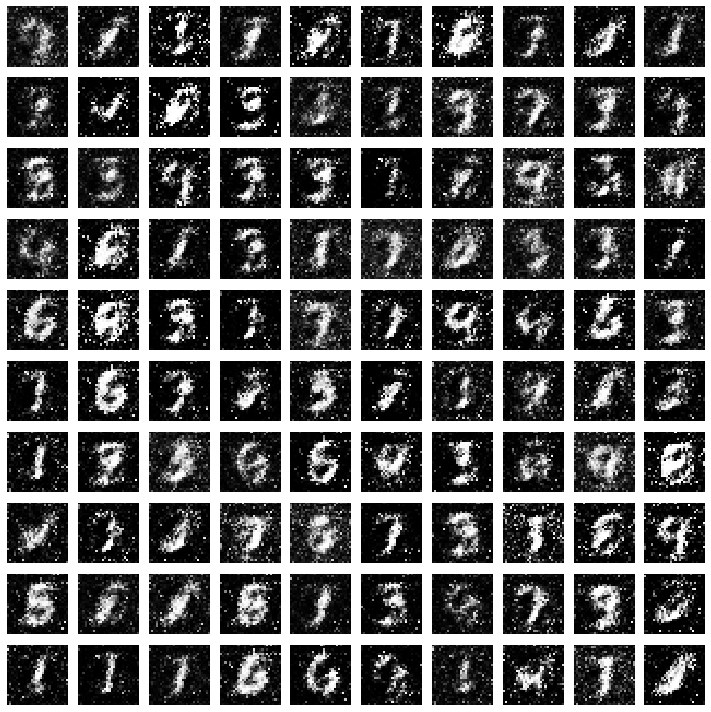

Epoch 6 Disc loss 0.5952 Generator loss 1.1916
Epoch 7 Disc loss 0.5908 Generator loss 1.2101
Epoch 8 Disc loss 0.6204 Generator loss 1.1227
Epoch 9 Disc loss 0.6309 Generator loss 1.0746
Epoch 10 Disc loss 0.6414 Generator loss 1.0362


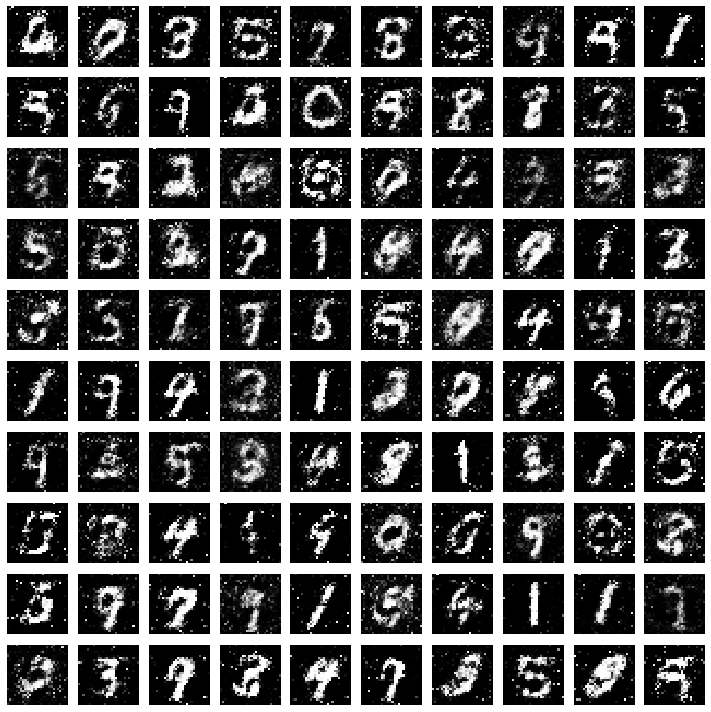

Epoch 11 Disc loss 0.6423 Generator loss 1.0248
Epoch 12 Disc loss 0.6477 Generator loss 0.9994
Epoch 13 Disc loss 0.6462 Generator loss 1.0035
Epoch 14 Disc loss 0.6454 Generator loss 1.0031
Epoch 15 Disc loss 0.6475 Generator loss 1.0014


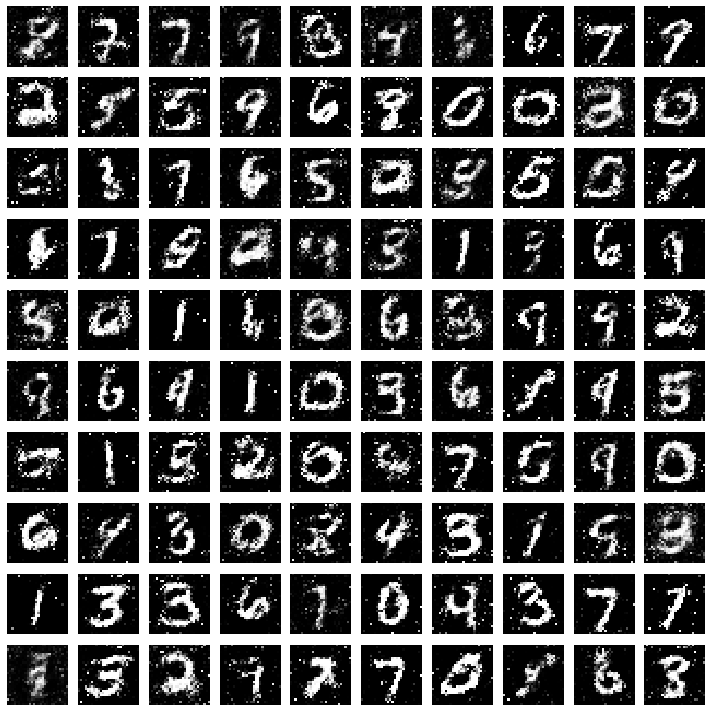

Epoch 16 Disc loss 0.6450 Generator loss 1.0079
Epoch 17 Disc loss 0.6446 Generator loss 1.0183
Epoch 18 Disc loss 0.6452 Generator loss 1.0066
Epoch 19 Disc loss 0.6478 Generator loss 1.0087
Epoch 20 Disc loss 0.6540 Generator loss 1.0031


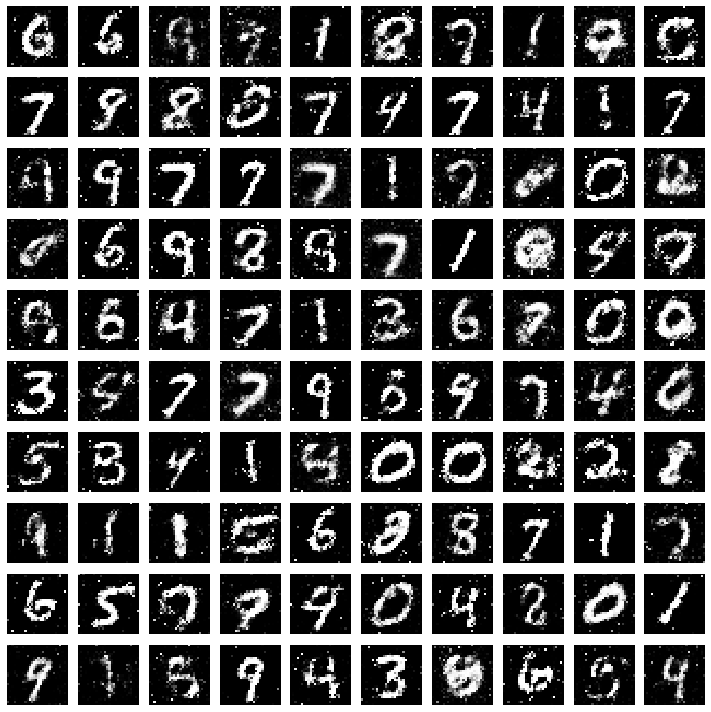

Epoch 21 Disc loss 0.6538 Generator loss 0.9883
Epoch 22 Disc loss 0.6555 Generator loss 0.9946
Epoch 23 Disc loss 0.6562 Generator loss 0.9925
Epoch 24 Disc loss 0.6571 Generator loss 0.9879
Epoch 25 Disc loss 0.6581 Generator loss 0.9881


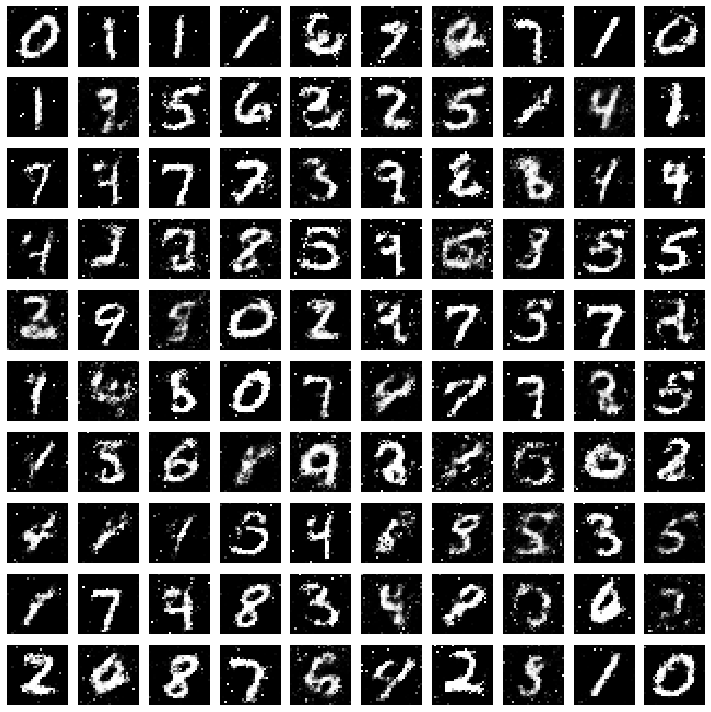

Epoch 26 Disc loss 0.6615 Generator loss 0.9792
Epoch 27 Disc loss 0.6607 Generator loss 0.9796
Epoch 28 Disc loss 0.6628 Generator loss 0.9773
Epoch 29 Disc loss 0.6623 Generator loss 0.9809
Epoch 30 Disc loss 0.6645 Generator loss 0.9772


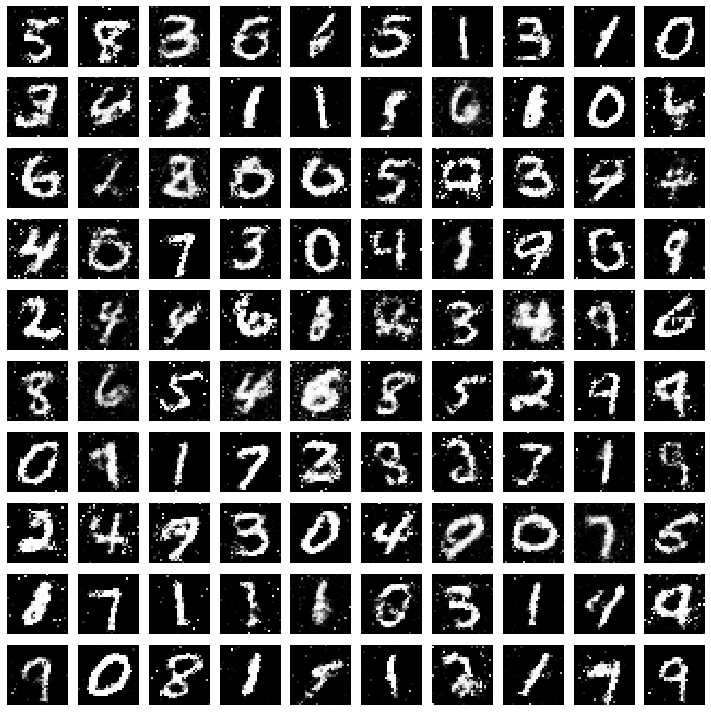

Epoch 31 Disc loss 0.6638 Generator loss 0.9786
Epoch 32 Disc loss 0.6631 Generator loss 0.9810
Epoch 33 Disc loss 0.6637 Generator loss 0.9770
Epoch 34 Disc loss 0.6653 Generator loss 0.9750
Epoch 35 Disc loss 0.6654 Generator loss 0.9742


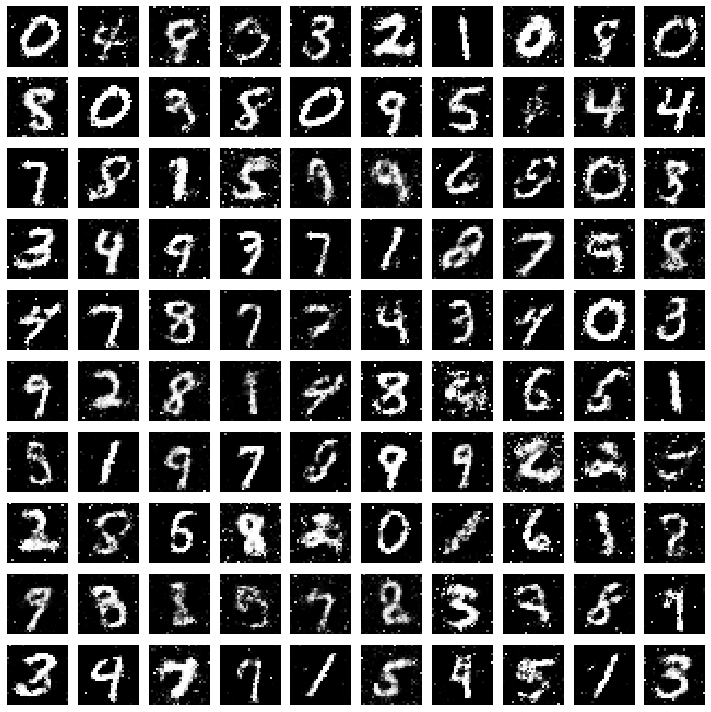

Epoch 36 Disc loss 0.6644 Generator loss 0.9754
Epoch 37 Disc loss 0.6660 Generator loss 0.9713
Epoch 38 Disc loss 0.6658 Generator loss 0.9791
Epoch 39 Disc loss 0.6664 Generator loss 0.9744
Epoch 40 Disc loss 0.6666 Generator loss 0.9724


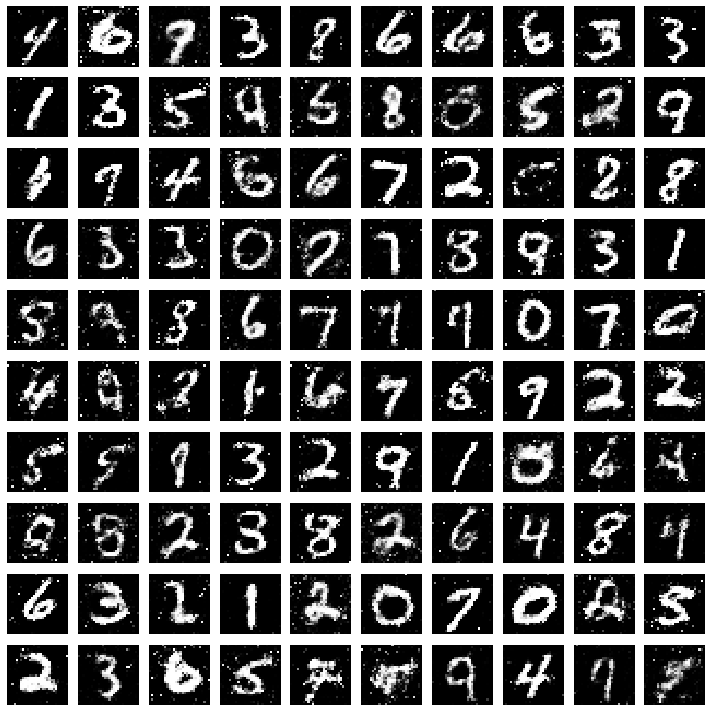

Epoch 41 Disc loss 0.6668 Generator loss 0.9700
Epoch 42 Disc loss 0.6669 Generator loss 0.9697
Epoch 43 Disc loss 0.6678 Generator loss 0.9654
Epoch 44 Disc loss 0.6672 Generator loss 0.9745
Epoch 45 Disc loss 0.6678 Generator loss 0.9659


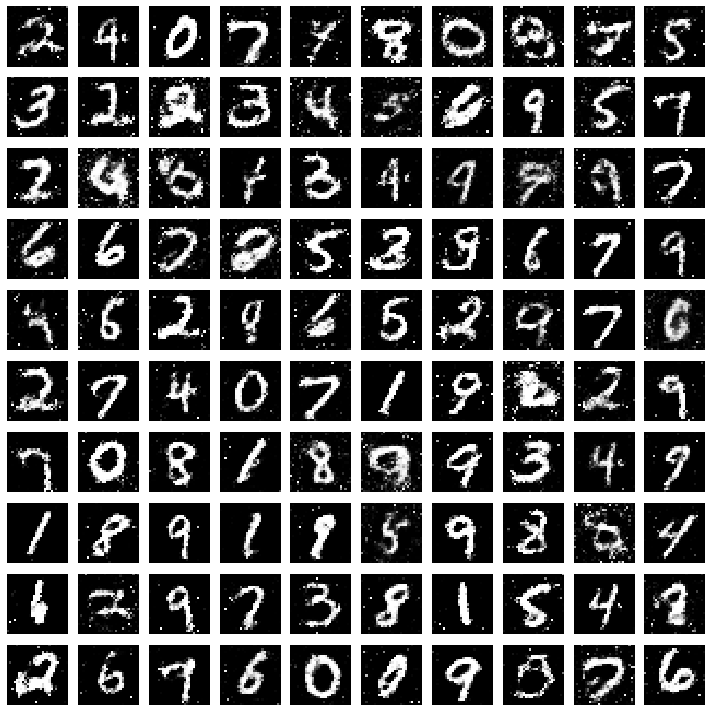

Epoch 46 Disc loss 0.6669 Generator loss 0.9719
Epoch 47 Disc loss 0.6674 Generator loss 0.9675
Epoch 48 Disc loss 0.6673 Generator loss 0.9717
Epoch 49 Disc loss 0.6682 Generator loss 0.9665
Epoch 50 Disc loss 0.6677 Generator loss 0.9683


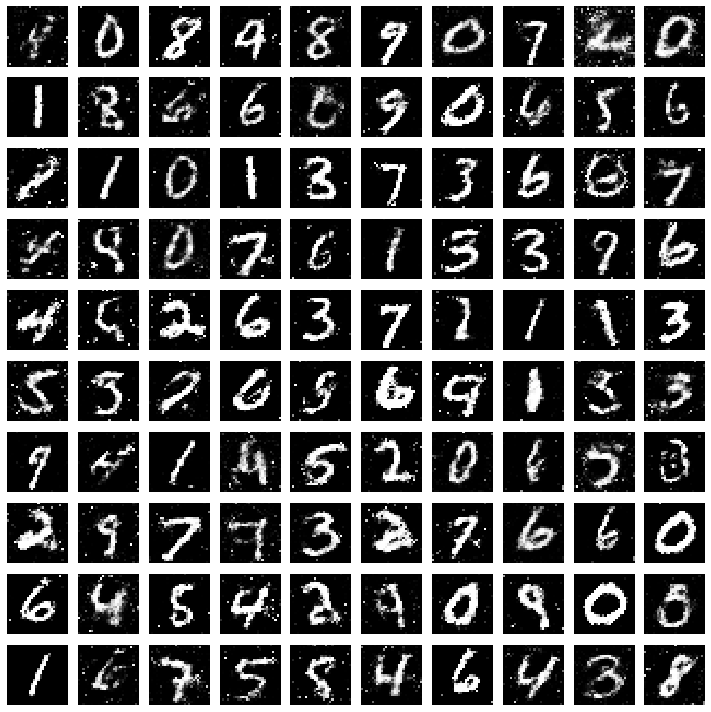

In [44]:
#Training Loop - Cannot use the fit function directly

d_losses = []
g_losses = []
for epoch in range(TOTAL_EPOCHS):
  epoch_d_loss=0.
  epoch_g_loss=0.
  
  #Mini Batch SGD - Stochastic Gradient Descent
  for step in range(NO_OF_BATCHES):

    #Step 1 : Discriminator
    # 50% real data + 50% fake data
    
    #Getting the Real data X 
    idx = np.random.randint(0,x_train.shape[0],HALF_BATCH)
    real_imgs = x_train[idx]

    #Getting the Fake data X
    noise = np.random.normal(0,1,size=(HALF_BATCH,NOISE_DIM))
    fake_imgs = generator.predict(noise)    #Forward pass through the generator to give us some fake images, while keeping the generator frozen.

    #Labels for real and fake images
    real_y = np.ones((HALF_BATCH,1))*0.9
    fake_y = np.zeros((HALF_BATCH,1))

    #Train our Discriminator 
    d_loss_real = discriminator.train_on_batch(real_imgs,real_y)
    d_loss_fake = discriminator.train_on_batch(fake_imgs,fake_y)
    d_loss = 0.5*d_loss_real + 0.5*d_loss_fake

    epoch_d_loss += d_loss

    #Train the Generator (Considering the discriminator frozen)
    noise = np.random.normal(0,1,size=(BATCH_SIZE,NOISE_DIM))
    ground_truth_y = np.ones((BATCH_SIZE,1))      #We are not using label smoothing
    g_loss = model.train_on_batch(noise,ground_truth_y)
    epoch_g_loss += g_loss

  print("Epoch %d Disc loss %.4f Generator loss %.4f" %((epoch+1),epoch_d_loss/NO_OF_BATCHES,epoch_g_loss/NO_OF_BATCHES))

  d_losses.append(epoch_d_loss/NO_OF_BATCHES)
  g_losses.append(epoch_g_loss/NO_OF_BATCHES)

  if (epoch+1)%5==0 :
    generator.save('/gan_generator_{0}.h5'.format(epoch+1))
    save_imgs(epoch)






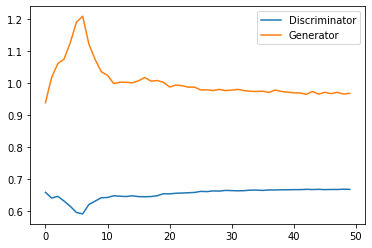

In [54]:
plt.plot(d_losses,label='Discriminator')
plt.plot(g_losses,label='Generator')
plt.legend()
plt.show()